In [1]:
import os
from pathlib import Path
import sys
curdir = Path(os.getcwd())
sys.path.append(str(curdir.parent.absolute()))
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from src.utils.data import read_fasta
from src.data.datasets import ProteinDataset
import numpy as np
from src.utils.data import read_pickle
from sklearn.metrics import precision_recall_curve

/anaconda/envs/protein_functions/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = read_fasta('../data/swissprot/proteinfer_splits/random/train_GO.fasta')
val = read_fasta('../data/swissprot/proteinfer_splits/random/dev_GO.fasta')
test = read_fasta('../data/swissprot/proteinfer_splits/random/test_GO.fasta')

In [6]:
from src.utils.configs import get_setup
from transformers import AutoTokenizer
(config, params, paths, paths_list, timestamp, logger, device, ROOT_PATH) = get_setup(
    config_path='../configs/base_config.yaml',
    run_name=None,
    overrides=None,
    log_to_console=True,
    train_path_name='TRAIN_DATA_PATH',
    val_path_name='VAL_DATA_PATH',
    test_paths_names=['TEST_DATA_PATH']
)


Logging to console...
2023-09-28 06:43:20 PDT INFO Using device: cuda


In [8]:
paths_list

[{'amino_acid_vocabulary_path': './data/vocabularies/amino_acid_vocab.json',
  'label_vocabulary_path': './data/vocabularies/GO_label_vocab.json',
  'sequence_id_vocabulary_path': './data/vocabularies/sequence_id_vocab.json',
  'go_annotations_path': './data/annotations/go_annotations_2019_07_01.pkl',
  'data_path': './data/swissprot/proteinfer_splits/random/train_GO.fasta',
  'dataset_type': 'train'},
 {'amino_acid_vocabulary_path': './data/vocabularies/amino_acid_vocab.json',
  'label_vocabulary_path': './data/vocabularies/GO_label_vocab.json',
  'sequence_id_vocabulary_path': './data/vocabularies/sequence_id_vocab.json',
  'go_annotations_path': './data/annotations/go_annotations_2019_07_01.pkl',
  'data_path': './data/swissprot/proteinfer_splits/random/dev_GO.fasta',
  'dataset_type': 'validation'},
 {'amino_acid_vocabulary_path': './data/vocabularies/amino_acid_vocab.json',
  'label_vocabulary_path': './data/vocabularies/GO_label_vocab.json',
  'sequence_id_vocabulary_path': './da

In [10]:

# Initialize label tokenizer
label_tokenizer = AutoTokenizer.from_pretrained(
    params['LABEL_ENCODER_CHECKPOINT'])

# Create datasets
datasets = ProteinDataset.create_multiple_datasets(
    [{'amino_acid_vocabulary_path': '../data/vocabularies/amino_acid_vocab.json',
    'label_vocabulary_path': '../data/vocabularies/GO_label_vocab.json',
    'sequence_id_vocabulary_path': '../data/vocabularies/sequence_id_vocab.json',
    'go_annotations_path': '../data/annotations/go_annotations_2019_07_01.pkl',
    'data_path': '../data/swissprot/proteinfer_splits/random/train_GO.fasta',
    'dataset_type': 'train'}],
    label_tokenizer=label_tokenizer,
    subset_fractions={
        "train": params["TRAIN_SUBSET_FRACTION"]}
)

In [21]:
from src.data.datasets import ProteinDataset, calculate_pos_weight, create_multiple_loaders
label_sample_sizes = {
    "train": params["TRAIN_LABEL_SAMPLE_SIZE"]
}
loaders = create_multiple_loaders(
    datasets,
    params,
    label_sample_sizes=label_sample_sizes,
    num_workers=params["NUM_WORKERS"],
)

In [28]:
a=iter(datasets['train'][0])


In [31]:
next(a)['label_multihots']

torch.Size([32102])

In [62]:
from joblib import Parallel, delayed, cpu_count
import torch


In [63]:
d = [('a',[1,'a','b','c']), ('b',[1,'z','b','c','a']), ('c',[1,'a','y','x'])]
calculate_label_weights(d)

{'a': 3.3333333333333335, 'b': 5.0, 'c': 5.0, 'z': 10.0, 'y': 10.0, 'x': 10.0}

In [39]:
a = Counter()
b = Counter()
a.update(['a', 'b', 'c'])
b.update(['a', 'b', 'c'])
all= [a, b]

In [40]:
#Summing counters with loop
c = Counter()
for i in all:
    c.update(i)


In [41]:
c

Counter({'a': 2, 'b': 2, 'c': 2})

Bad pipe message: %s [b"\x03>\xeb\xa1\xcf\xada\xe4\xf0\x9b\xe2\xe6\xa3R'\xacw. \x9e\x8b[Zl\xfe\xefC\x1f\xe2G\xda"]
Bad pipe message: %s [b"\xd4E\xaf\xa1\xfb\xb5\xf2\n\x89&\xaa\xa5\t\xc1%\xc7v`\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11"]
Bad pipe message: %s [b"\xec\x84\xff\xfc\xce\x02\xb3\xeck>!C\xbb>\xac\x9d\xbc\xdf\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0s\xc0w\x00\xc4\x00\xc3\xc0#\xc0'\x00g\x00@\xc0r\xc0v\x00\xbe\x00\xbd\xc0\n\xc0\x14\x009\x008\x00\x88\x00\x87\xc0\t\xc0\

In [20]:
train = [(k[0],j," ".join(k[1:])) for j,k in train]
test = [(k[0],j," ".join(k[1:])) for j,k in test]
val = [(k[0],j," ".join(k[1:])) for j,k in val]

df = train + val + test

In [21]:
df = pd.DataFrame(df,columns=['id','sequence','labels'])

In [22]:
num_sequences = len(df)
print('number of sequences:',num_sequences)

number of sequences: 522607


In [23]:
df.head()

,id,sequence,labels
0,P60545,MSKIIEYDETARRAIEAGVNTLADAVRVTLGPRGRHVVLAKAFGGP...,GO:0035639 GO:0032553 GO:0005524 GO:0017076 GO...
1,Q3KEX7,MKFSEQWLRGWVSPQVDRDALVARLSMAGLEVDSVTPAAGVFSGVV...,GO:0016070 GO:0035639 GO:0004812 GO:0032553 GO...
2,Q8D2U1,MKSVSIIDIIEKKIFKKKLVEINGWVRTKRNSKLGISFVDVYDGSC...,GO:0016070 GO:0004812 GO:0035639 GO:0032553 GO...
3,Q95KN1,MKPSLLVFTVYLLWLKDCHCAPTWKDKTDMHGNLKGFSEAGDIDVD...,GO:0044424 GO:0003674 GO:0044464 GO:0043226 GO...
4,Q98HL0,MNSLDLPGRPENTRIVVAMSGGVDSSVVAGLLKREGYDVVGVTLQL...,GO:0016070 GO:0035639 GO:0032553 GO:0005524 GO...


In [24]:
df['num_pos'] = df['labels'].str.split(' ').str.len()

In [25]:
df['num_pos'].describe()

count    522607.000000
mean         47.743901
std          38.433523
min           2.000000
25%          25.000000
50%          43.000000
75%          59.000000
max        1008.000000
Name: num_pos, dtype: float64

In [26]:
labels = Counter()

vocab = set()
amino_freq = Counter()
for idx,row in df.iterrows():
    sequence = row['sequence']
    row_labels = row['labels']
    aa_list = list(sequence)
    if row_labels =='':
        print(row['id'],row['labels'])
    vocab.update(aa_list)
    amino_freq.update(aa_list)
    labels.update(row_labels.split(" "))

In [27]:
print('# GO Terms:',len(labels.keys()))

# GO Terms: 32102


In [33]:
print('GO Terms distribution')
go_term_distribution = pd.Series(labels.values(),index=labels.keys()).sort_values(ascending=False)
go_term_distribution.describe()

GO Terms distribution


count     32102.000000
mean        777.250545
std        9114.786603
min           1.000000
25%           4.000000
50%          17.000000
75%          84.000000
max      462356.000000
dtype: float64

In [36]:
go_term_distribution*100/num_sequences

GO:0003674    88.471069
GO:0008150    82.899961
GO:0005575    77.051015
GO:0009987    70.664955
GO:0044464    69.697880
                ...    
GO:0030290     0.000191
GO:0070455     0.000191
GO:0044663     0.000191
GO:1903856     0.000191
GO:0047004     0.000191
Length: 32102, dtype: float64

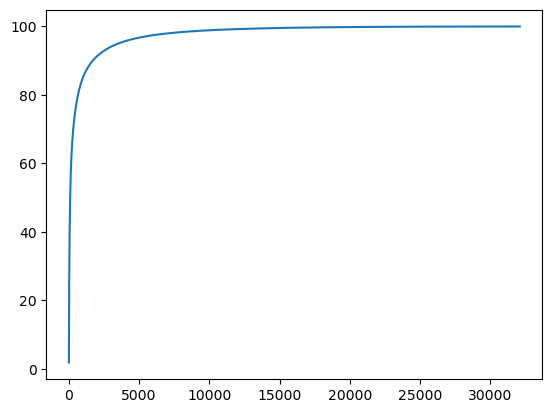

In [51]:
# Cumulative distribution of GO terms. Shows the number of GO terms that cover X% of the data
plt.plot(range(len(go_term_distribution)),(go_term_distribution*100/go_term_distribution.sum()).cumsum())

In [9]:
print('Sequence length distribution')

df['sequence'].apply(len).describe()

Sequence length distribution


count    522607.000000
mean        368.042215
std         334.721845
min           2.000000
25%         179.000000
50%         303.000000
75%         456.000000
max       35213.000000
Name: sequence, dtype: float64

# Explore Model Predictions

In [2]:
val_labels = pd.read_parquet("../results/labels_ProTCL.parquet")
val_probabilities = pd.read_parquet("../results/probabilities_ProTCL.parquet")

In [3]:
val_probabilities.head()

,GO:0000001,GO:0000002,GO:0000003,GO:0000006,GO:0000007,GO:0000009,GO:0000010,GO:0000011,GO:0000012,GO:0000014,...,GO:2001305,GO:2001306,GO:2001307,GO:2001308,GO:2001310,GO:2001311,GO:2001313,GO:2001315,GO:2001316,GO:2001317
441261,0.000000,0.000000,0.000025,0.000000e+00,5.960464e-07,8.940697e-07,4.839897e-04,0.000000,0.000000,0.000000e+00,...,0.003063,0.000000,0.000000e+00,1.192093e-07,0.000000e+00,0.000005,0.000097,2.384186e-07,1.345634e-03,0.000000
99304,0.000000,0.000000,0.000025,0.000000e+00,5.960464e-07,8.940697e-07,4.839897e-04,0.000000,0.000000,0.000000e+00,...,0.003063,0.000000,0.000000e+00,1.192093e-07,0.000000e+00,0.000005,0.000097,2.384186e-07,1.345634e-03,0.000000
173323,0.003944,0.029083,0.142822,5.960464e-08,5.960464e-08,2.065897e-04,1.713037e-04,0.018616,0.004868,1.950073e-02,...,0.000477,0.000002,2.148151e-04,8.644104e-03,3.780365e-03,0.000042,0.000488,2.694130e-04,2.323389e-04,0.000073
480469,0.135742,0.071838,0.001531,4.470348e-06,8.046627e-06,0.000000e+00,0.000000e+00,0.062103,0.000126,2.026558e-06,...,0.000000,0.000001,5.960464e-08,7.545948e-05,4.506111e-05,0.000077,0.000000,0.000000e+00,5.364418e-06,0.000003
38932,0.000001,0.000389,0.000111,0.000000e+00,0.000000e+00,0.000000e+00,5.960464e-08,0.000000,0.000000,5.960464e-08,...,0.000000,0.000000,0.000000e+00,4.172325e-07,5.960464e-08,0.000000,0.000000,0.000000e+00,1.788139e-07,0.000003


In [4]:
th = 0.97
val_preds = (val_probabilities>th)*1
tps = (val_labels*val_preds)*1
fps = ((1-val_labels)*val_preds)*1
tns = ((1-val_labels)*(1-val_preds))*1
fns = (val_labels*(1-val_preds))*1

In [5]:
recall_micro = tps.sum().sum()/(tps.sum().sum()+fns.sum().sum()) 
precision_micro = tps.sum().sum()/(tps.sum().sum()+fps.sum().sum())
f1_micro = 2*recall_micro*precision_micro/(recall_micro+precision_micro)

#Do the same for macro scores by computing metrics per class and then averaging. Each class is a column in the dataframe.

recall_macro = (tps.sum(axis=0)/(tps.sum(axis=0)+fns.sum(axis=0))).fillna(0)
precision_macro = (tps.sum(axis=0)/(tps.sum(axis=0)+fps.sum(axis=0))).fillna(0)
f1_macro = (2*recall_macro*precision_macro/(recall_macro+precision_macro)).fillna(0)
positive_preds = (tps.sum(axis=0)+fps.sum(axis=0)).fillna(0).astype(bool)



In [72]:
val_go_term_popularity = (val_labels.sum(axis=0)*100/val_labels.shape[0]).sort_values(ascending=False)
val_go_term_distribution = (val_labels.sum(axis=0)*100/val_labels.sum().sum()).sort_values(ascending=False)

In [7]:
#Concatenate class metrics with go term popularity
val_class_metrics = pd.concat([recall_macro,precision_macro,f1_macro,val_go_term_popularity],axis=1,
                              keys=['recall','precision','f1','popularity'])

/tmp/ipykernel_775718/228177422.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=binned,x='bin',y='value',marker='.',ci=95)


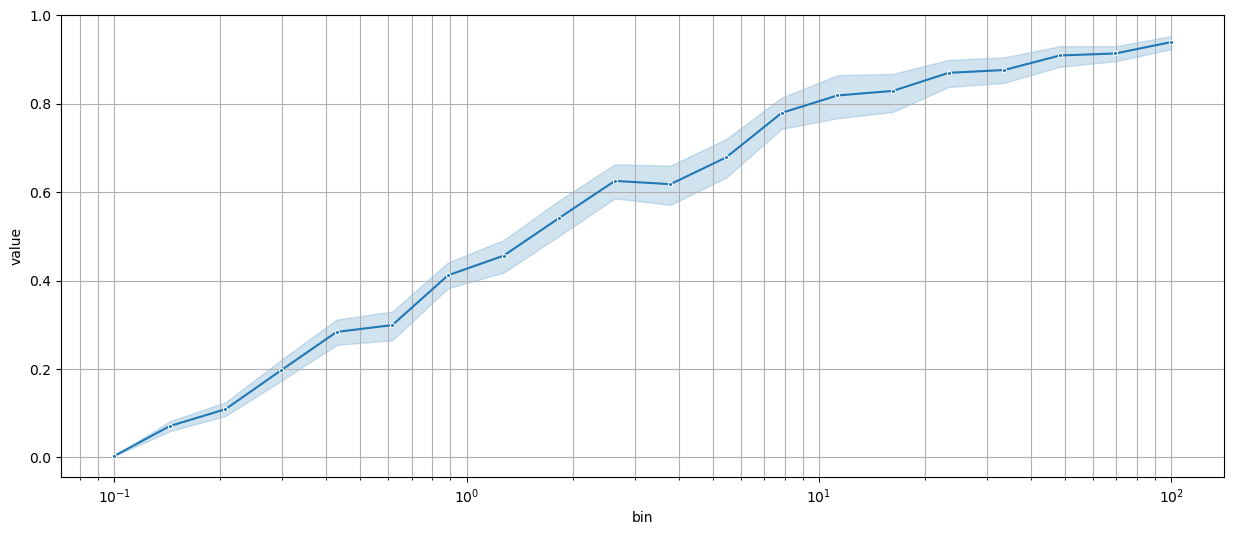

In [77]:
import seaborn as sns

#Plot popularity vs f1 score with 2d heatmap using bins. Bins should be in log space
bins = np.logspace(-1, np.log10(100), 20)
digitized = np.digitize(val_class_metrics['popularity'], bins)
binned = pd.DataFrame({'bin':bins[digitized],'value':val_class_metrics['f1']})

plt.subplots(figsize=(15,6))
sns.lineplot(data=binned,x='bin',y='value',marker='.',ci=95)
plt.grid(which='both')
plt.xscale('log')




In [56]:
f1_macro.loc[val_go_term_popularity[val_go_term_popularity>1].index.unique()].mean()

0.6333135356807155

In [76]:
val_go_term_distribution[positive_preds[positive_preds].index].sum()

93.34485269605015

In [85]:
val_go_term_popularity[positive_preds[positive_preds].index].sort_values(ascending=False)

count    4940.000000
mean        0.902110
std         4.373502
min         0.000000
25%         0.011355
50%         0.087054
75%         0.358150
max        88.539203
dtype: float64

In [67]:
positive_preds.sum()

4940